<a href="https://colab.research.google.com/github/analystanand/Contact_Management_System/blob/master/resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import time
from tqdm import tqdm
from tqdm import tqdm_notebook
%matplotlib inline

In [0]:
class NormalBlock(nn.Module):
    vol_expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(NormalBlock, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(out_channels)
        self.conv_layer2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(out_channels)

        self.skip_layer = nn.Sequential()
        if stride != 1 or in_channels != self.vol_expansion*out_channels:
            self.skip_layer = nn.Sequential(
                nn.Conv2d(in_channels, self.vol_expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.vol_expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.batch_norm_1(self.conv_layer1(x)))
        out = self.batch_norm_2(self.conv_layer2(out))
        out += self.skip_layer(x)
        out = F.relu(out)
        return out

In [0]:
class BottleneckBlock(nn.Module):
    vol_expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()

        self.conv_layer1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(out_channels)

        self.conv_layer2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(out_channels)

        self.conv_layer3 = nn.Conv2d(out_channels, self.vol_expansion * out_channels, kernel_size=1, bias=False)
        self.batch_norm_3 = nn.BatchNorm2d(self.vol_expansion * out_channels)

        self.skip_layers = nn.Sequential()
        if stride != 1 or in_channels != self.vol_expansion * out_channels:
            self.skip_layers = nn.Sequential(
                nn.Conv2d(in_channels, self.vol_expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.vol_expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.batch_norm_1(self.conv_layer1(x)))
        out = F.relu(self.batch_norm_2(self.conv_layer2(out)))
        out = self.batch_norm_3(self.conv_layer3(out))
        out += self.skip_layers(x)
        out = F.relu(out)
        return out

In [0]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv_layer1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.vol_expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.vol_expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv_layer1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [0]:
def ResNet18():
    return ResNet(NormalBlock, [2,2,2,2])

def ResNet34():
    return ResNet(NormalBlock, [3,4,6,3])

def ResNet50():
    return ResNet(BottleneckBlock, [3,4,6,3])

def ResNet101():
    return ResNet(BottleneckBlock, [3,4,23,3])

def ResNet152():
    return ResNet(BottleneckBlock, [3,8,36,3])


In [6]:
# training data transformation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470,0.2435,0.2616))])

# training data loader
train_set = torchvision.datasets.CIFAR10(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform_train)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
# test data transformation
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435,0.2616))])
# test data loader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=32,
                                          shuffle=False,
                                          num_workers=2)


Files already downloaded and verified


In [0]:

def train_model(model, loss_function, optimizer, data_loader):
    # set model to training mode
    model.train()

    current_loss = 0.0
    current_acc = 0

    # iterate over the training data

    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)


    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Train Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss,
    total_acc))
    return total_loss, total_acc

In [0]:
def test_model(model, loss_function, data_loader):
    # set model in evaluation mode
    model.eval()

    current_loss = 0.0
    current_acc = 0

    # iterate over  the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Test Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss,total_acc))

    return total_loss, total_acc

In [0]:
def plot_accuracy(test_accuracy: list,train_accuracy,model_name,ep):
    """Plot accuracy"""
    plt.figure()
    x =  range(1,ep+1)
    plt.plot(x,test_accuracy,color='b',label='Test')
    plt.plot(x,train_accuracy,color='r',label='Train')
    plt.title(model_name)
    # plt.xticks(
    #     [i for i in range(0, len(accuracy))],
    #     [i + 1 for i in range(0, len(accuracy))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    # plt.savefig('{}.png'.format(model_name))


Model: ResNet18
Epoch 1/50
Train Loss: 1.6403; Accuracy: 0.3878
Test Loss: 1.3323; Accuracy: 0.5109
Epoch 2/50
Train Loss: 1.2147; Accuracy: 0.5600
Test Loss: 1.0753; Accuracy: 0.6245
Epoch 3/50
Train Loss: 1.0283; Accuracy: 0.6325
Test Loss: 0.9517; Accuracy: 0.6615
Epoch 4/50
Train Loss: 0.9018; Accuracy: 0.6783
Test Loss: 0.8521; Accuracy: 0.6945
Epoch 5/50
Train Loss: 0.8207; Accuracy: 0.7072
Test Loss: 0.7805; Accuracy: 0.7257
Epoch 6/50
Train Loss: 0.7481; Accuracy: 0.7347
Test Loss: 0.7447; Accuracy: 0.7458
Epoch 7/50
Train Loss: 0.6848; Accuracy: 0.7602
Test Loss: 0.6606; Accuracy: 0.7656
Epoch 8/50
Train Loss: 0.6367; Accuracy: 0.7764
Test Loss: 0.6131; Accuracy: 0.7864
Epoch 9/50
Train Loss: 0.5825; Accuracy: 0.7960
Test Loss: 0.5867; Accuracy: 0.7991
Epoch 10/50
Train Loss: 0.5399; Accuracy: 0.8108
Test Loss: 0.5695; Accuracy: 0.8051
Epoch 11/50
Train Loss: 0.5001; Accuracy: 0.8234
Test Loss: 0.5297; Accuracy: 0.8204
Epoch 12/50
Train Loss: 0.4671; Accuracy: 0.8363
Test Los

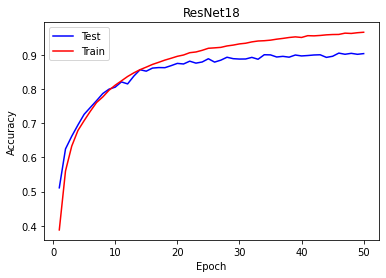

In [11]:
if __name__ == '__main__':
    modelname_list = ['ResNet18','ResNet34','ResNet50','ResNet101','ResNet152']
    models_list = [ResNet18(),ResNet34(),ResNet50(),ResNet101(),ResNet152()]

    for i in range(len(models_list[:1])):
        start_time = time.time()
        name = modelname_list[i]
        print("Model:",name)
        model = models_list[i]
        # select gpu 0, if available# otherwise fallback to cpu
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # transfer the model to the GPU
        model = model.to(device)
        # loss function
        loss_function = nn.CrossEntropyLoss()
        # We'll optimize all parameters
        optimizer = optim.Adam(model.parameters())

        EPOCHS = 50
        # with tqdm(total=EPOCHS) as pbar:
        test_acc,train_acc = [],[]  # collect accuracy for plotting
        for epoch in range(EPOCHS):
            print('Epoch {}/{}'.format(epoch + 1, EPOCHS))

            train_loss,train_accuracy = train_model(model, loss_function, optimizer, train_loader)
            test_loss, test_accuracy = test_model(model, loss_function, test_loader)
            train_acc.append(train_accuracy)
            test_acc.append(test_accuracy)
              # pbar.update(1)
        # pbar.close()
        # torch.save(model, PATH)
        endtime = time.time() - start_time
        print("Endtime %s seconds",endtime)
        plot_accuracy(test_acc,train_acc,name,EPOCHS)
